In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn import metrics
import re
import time
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

#Quality of image:
%config InlineBackend.figure_format = 'svg'
import os


from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold


pd.set_option('display.max_columns', 100)

# Import my own functions from utils file:
import import_ipynb
from Utils_Car_Insurance import *

importing Jupyter notebook from Utils_Car_Insurance.ipynb


### Reading Files:

In [2]:
dataDirectory = os.path.join(os.path.dirname(os.getcwd()),'Car_Insurance\\data\\After_EDA')
imageDirectory = os.path.join(os.path.dirname(os.getcwd()),'Car_Insurance\\images\\modeling')

In [3]:
X = pd.read_csv(dataDirectory + "\\X_train_imp_feature.csv")
X_test = pd.read_csv(dataDirectory + "\\X_test_imp_feature.csv")

y = pd.read_csv(dataDirectory + "\\y_train.csv")
y_test = pd.read_csv(dataDirectory + "\\y_test.csv")

### Spliting X, y to train and validation dataset:

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state=123, stratify= y)

In [4]:
# Continue this cell

def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return [('gini', gini_score)]

### <font color=blue>Using low-level API to train the model via gradient boosting method</font>
#### Starting point: Runing XGB with default parameters

In [6]:
"""
- Xgboost is short for Xtreme Gradient Boosting package.

- max_depth: determines how deeply each tree is allowed to grow during any boosting round. (default=6)

- subsample: percentage of samples used per tree. Low value can lead to underfitting. (default=1)

- colsample_bytree: percentage of features used per tree. High value can lead to overfitting. (default=1)

- silent=True, will be used for printing messages, it will supress message..

- eta [default=0.3, alias: learning_rate]
    - Step size shrinkage used in update to prevents overfitting. 
    After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to
    make the boosting process more conservative.
    - range: [0,1]
 
- min_child_weight [default=1]:
    Minimum sum of instance weight needed in a child. 
    In linear regression task, this simply corresponds to minimum number of instances needed to be in each node.
    It is used to control over-fitting.
    The larger min_child_weight is, the more conservative the algorithm will be.    
    Too high values can lead to under-fitting hence, it should be tuned using CV.


- objective: determines the loss function to be used like:
    reg:linear for regression problems,
    reg:logistic for classification problems with only decision,
    binary:logistic for classification problems with probability.
    
eval_metric: Evaluation metrics for validation data, a default metric will be assigned according to objective
    - rmse for regression,
    - error or auc for classification,

- Difference between (eval_metric and feval):
    - Both of them are used for to evaluate the model.
    - eval_metric is for metrics which are implemented already inside xgboost package like:
        - it's a string, e.g. rmse / logloss/ mlogloss/ merror/ error/ auc/ aucpr ...
    - In contrast, feval is useful when we want to create our own customized evaluation metric.
        - it must be a (custom, user-defined) function
"""

xgb_params = {'eta': 0.3, 
              'max_depth': 6, 
              'subsample': 1.0, 
              'colsample_bytree': 1,
              'min_child_weight': 1,
              'objective': 'binary:logistic',  
              'seed': 123, 
              'silent': True}

# By using hold out validation:  
d_train = xgb.DMatrix(X_train, y_train)
d_valid = xgb.DMatrix(X_val,y_val)
d_test = xgb.DMatrix(X_test)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

model = xgb.train(xgb_params,
                  d_train,
                  num_boost_round=1200,
                  evals = watchlist,
                  feval=gini_xgb,
                  maximize=True,
                  verbose_eval=100,
                  early_stopping_rounds=200)

print(model.best_score, model.best_iteration, model.best_ntree_limit)

[10:45:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:45:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.47307	train-gini:0.22179	valid-logloss:0.47319	valid-gini:0.20534
[100]	train-logloss:0.13346	train-gini:0.59453	valid-logloss:0.15441	valid-gini:0.23031
[200]	train-logloss:0.12208	train-gini:0.71293	valid-logloss:0.15646	valid-gini:0.20791
[224]	train-logloss:0.11934	train-gini:0.738

In [9]:
models = pd.DataFrame(index= ['Gini_Score'], columns=['Default', 'After_Eta', 'After_MaxDepth', 'After_Min_Child', 'After_Col_Sample'])
models

,Default,After_Eta,After_MaxDepth,After_Min_Child,After_Col_Sample
Gini_Score,NaN,NaN,NaN,NaN,NaN


In [12]:
preds = model.predict(d_test)
score = gini_normalized(y_test, preds)
print("The score: {:0.5f}".format(score))
models.loc['Gini_Score', 'Default'] = score
models

The score: 0.20388


,Default,After_Eta,After_MaxDepth,After_Min_Child,After_Col_Sample
Gini_Score,0.203877,NaN,NaN,NaN,NaN


### Step 1: Tunning of eta:

In [13]:
results = {'eta':[],'best_score':[],'best_ntree_limit':[]}

for i, e in enumerate([0.02, 0.05, 0.3, 0.5]):
    xgb_params = {'eta': e, 
                  'max_depth': 6, 
                  'subsample': 1.0, 
                  'colsample_bytree': 1,
                  'min_child_weight': 1,
                  'objective': 'binary:logistic', 
                  'seed': 123, 
                  'silent': True}

    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    model = xgb.train(xgb_params, d_train, 1200,  watchlist, feval=gini_xgb, maximize=True, verbose_eval=100, early_stopping_rounds=200)
    if i ==0:
        model_0 = model
    elif i == 1:
        model_1 = model
    elif i == 2:
        model_2 = model
    elif i == 3:
        model_3 = model    
    results['best_score'].append(model.best_score)
    results['best_ntree_limit'].append(model.best_ntree_limit)
    results['eta'].append(e)

    
eta_df=pd.DataFrame({'best_score': results['best_score'],
                     'best_ntree_limit':results['best_ntree_limit']},
                    index = results['eta'])
eta_df.index.name = 'eta'

[10:55:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:55:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.67641	train-gini:0.22179	valid-logloss:0.67606	valid-gini:0.20534
[100]	train-logloss:0.18034	train-gini:0.28797	valid-logloss:0.18151	valid-gini:0.23826
[200]	train-logloss:0.15032	train-gini:0.34481	valid-logloss:0.15341	valid-gini:0.25931
[300]	train-logloss:0.14686	train-gini:0.392

In [14]:
eta_df=pd.DataFrame({'best_validation_score': results['best_score'],'best_ntree_limit':results['best_ntree_limit']},
                    index = results['eta'])
eta_df.index.name = 'eta'
eta_df

,best_validation_score,best_ntree_limit
eta,,
0.02,0.275244,430
0.05,0.276337,183
0.30,0.261549,25
0.50,0.256244,10


### <font color=blue>Best found parameter: "Eta=0.05"</font>

In [18]:
preds = model_1.predict(d_test)
score = gini_normalized(y_test, preds)
print("The score: {:0.5f}".format(score))
models.loc['Gini_Score', 'After_Eta'] = score
models

The score: 0.26788


,Default,After_Eta,After_MaxDepth,After_Min_Child,After_Col_Sample
Gini_Score,0.203877,0.267876,NaN,NaN,NaN


### Step 2: Tunning of max_depth:

In [20]:
results = {'max_depth':[],'best_score':[],'best_ntree_limit':[]}
for i, m in enumerate([4,5,7]):
    xgb_params = {'eta': 0.05, 
                  'max_depth': m, 
                  'subsample': 1.0, 
                  'colsample_bytree': 1,
                  'min_child_weight': 1,
                  'objective': 'binary:logistic', 
                  'eval_metric': 'auc', 
                  'seed': 123, 
                  'silent': True}
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    model = xgb.train(xgb_params, d_train, 1200,  watchlist, feval=gini_xgb,
                      maximize=True, verbose_eval=100, early_stopping_rounds=200)
    if i ==0:
        model_0 = model
    elif i == 1:
        model_1 = model
    elif i == 2:
        model_2 = model
    results['best_score'].append(model.best_score)
    results['best_ntree_limit'].append(model.best_ntree_limit)
    results['max_depth'].append(m)


max_depth_df=pd.DataFrame({'best_validation_score': results['best_score'],'best_ntree_limit':results['best_ntree_limit']},
                          index = results['max_depth'])
max_depth_df.index.name = 'max_depth'
max_depth_df    

[11:40:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.60002	train-gini:0.20100	valid-auc:0.59695	valid-gini:0.19390
[100]	train-auc:0.64929	train-gini:0.29858	valid-auc:0.63071	valid-gini:0.26142
[200]	train-auc:0.66931	train-gini:0.33863	valid-auc:0.63839	valid-gini:0.27679
[300]	train-auc:0.68092	train-gini:0.36184	valid-auc:0.63872	valid-gini:0.27745
[400]	train-auc:0.69092	train-gini:0.38184	valid-auc:0.63903	valid-gini:0.27805
[500]	train-auc:0.69991	train-gini:0.39982	valid-auc:0.63784	valid-gini:0.27568
[553]	train-auc:0.70401	train-gini:0.40801	valid-auc:0.63767	valid-gini:0.27533
[11:45:58] WARNING: C:/Users/Administrator/workspace/xgboo

,best_validation_score,best_ntree_limit
max_depth,,
4,0.278598,354
5,0.277635,197
7,0.272249,153


### <font color=blue>Best found parameter: "Max_depth=4"</font>

In [21]:
preds = model_0.predict(d_test)
score = gini_normalized(y_test, preds)
print("The score: {:0.5f}".format(score))
models.loc['Gini_Score', 'After_MaxDepth'] = score
models

The score: 0.27284


,Default,After_Eta,After_MaxDepth,After_Min_Child,After_Col_Sample
Gini_Score,0.203877,0.267876,0.272841,NaN,NaN


### Step 3: Tunning of min_child_weight:

In [22]:
results = {'min_child':[],'best_score':[],'best_ntree_limit':[]}
    
for i, m in enumerate([2, 4, 6]):
    xgb_params = {'eta': 0.05, 
                  'max_depth': 4, 
                  'subsample': 1.0, 
                  'colsample_bytree': 1,
                  'min_child_weight': m,
                  'objective': 'binary:logistic',  
                  'seed': 123, 
                  'silent': True}

    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    model = xgb.train(xgb_params, d_train, 1200,  watchlist, feval=gini_xgb,
                  maximize=True, verbose_eval=100, early_stopping_rounds=200)
    
    if i ==0:
        model_0 = model
    elif i == 1:
        model_1 = model
    elif i == 2:
        model_2 = model

    results['best_score'].append(model.best_score)
    results['best_ntree_limit'].append(model.best_ntree_limit)
    results['min_child'].append(m)

    
min_child_df=pd.DataFrame({'best_validation_score': results['best_score'],'best_ntree_limit':results['best_ntree_limit']},
                          index = results['min_child'])
min_child_df.index.name = 'min_child_weight'
min_child_df

[12:03:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:03:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.65158	train-gini:0.20444	valid-logloss:0.65116	valid-gini:0.19518
[100]	train-logloss:0.15131	train-gini:0.29841	valid-logloss:0.15251	valid-gini:0.25937
[200]	train-logloss:0.14929	train-gini:0.33915	valid-logloss:0.15176	valid-gini:0.27667
[300]	train-logloss:0.14819	train-gini:0.363

,best_validation_score,best_ntree_limit
min_child_weight,,
2,0.277792,248
4,0.277815,323
6,0.279258,441


### <font color=blue>Best found parameter: "min_child_w=6"</font>

In [23]:
preds = model_2.predict(d_test)
score = gini_normalized(y_test, preds)
print("The score: {:0.5f}".format(score))
models.loc['Gini_Score', 'After_Min_Child'] = score
models

The score: 0.27264


,Default,After_Eta,After_MaxDepth,After_Min_Child,After_Col_Sample
Gini_Score,0.203877,0.267876,0.272841,0.272638,NaN


### Step 4: Tunning of colsample_bytree:

In [24]:
results = {'colsample':[],'best_score':[],'best_ntree_limit':[]}
for i, c in enumerate([0.3, 0.5, 0.8]):
    xgb_params = {'eta': 0.05, 
                  'max_depth': 4, 
                  'subsample': 1.0, 
                  'colsample_bytree': c,
                  'min_child_weight': 6,
                  'objective': 'binary:logistic',
                  'seed': 123, 
                  'silent': True}

    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    model = xgb.train(xgb_params, d_train, 1200,  watchlist, feval=gini_xgb, maximize=True, verbose_eval=100, early_stopping_rounds=200)
    if i ==0:
        model_0 = model
    elif i == 1:
        model_1 = model
    elif i == 2:
        model_2 = model

    results['best_score'].append(model.best_score)
    results['best_ntree_limit'].append(model.best_ntree_limit)
    results['colsample'].append(c)

colsample_df=pd.DataFrame({'best_validation_score': results['best_score'],'best_ntree_limit':results['best_ntree_limit']},
                          index = results['colsample'])
colsample_df.index.name = 'colsample_bytree'
colsample_df

[12:25:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:25:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.65144	train-gini:0.18647	valid-logloss:0.65118	valid-gini:0.16972
[100]	train-logloss:0.15160	train-gini:0.29245	valid-logloss:0.15268	valid-gini:0.25435
[200]	train-logloss:0.14973	train-gini:0.32959	valid-logloss:0.15182	valid-gini:0.27391
[300]	train-logloss:0.14881	train-gini:0.351

,best_validation_score,best_ntree_limit
colsample_bytree,,
0.3,0.278324,329
0.5,0.281976,354
0.8,0.279440,258


### <font color=blue>Best found parameter: "colsample_bytree=0.8"</font>

In [25]:
preds = model_2.predict(d_test)
score = gini_normalized(y_test, preds)
print("The score: {:0.5f}".format(score))
models.loc['Gini_Score', 'After_Col_Sample'] = score
models

The score: 0.27597


,Default,After_Eta,After_MaxDepth,After_Min_Child,After_Col_Sample
Gini_Score,0.203877,0.267876,0.272841,0.272638,0.275969


### <font color=blue>Finally, training model on the full dataset:"</font>
- We have to set the optimized paramneters,
- The key for the final train is setting of the paramter: **num_boost_round**,
- We will set it = 259 according to the last result of **best_ntree_limit**.

In [28]:
d_train = xgb.DMatrix(X, y)
xgb_params = {'eta': 0.05,
              'max_depth': 4, 
              'subsample': 1.0, 
              'colsample_bytree': 0.8,
              'min_child_weight': 1,
              'objective': 'binary:logistic',  
              'seed': 123, 
              'silent': True}

watchlist = [(d_train, 'train')]
final_model = xgb.train(xgb_params, d_train, 259, watchlist, feval=gini_xgb,
              maximize=True, verbose_eval=100, early_stopping_rounds=200)

[12:59:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:59:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.65165	train-gini:0.20286
[100]	train-logloss:0.15152	train-gini:0.29339
[200]	train-logloss:0.14973	train-gini:0.32793
[258]	train-logloss:0.14915	train-gini:0.34073


### <font color=blue>Prediction with final model</font>

In [29]:
preds = final_model.predict(d_test)
scoreFinal = gini_normalized(y_test, preds)
scoreFinal

0.2786422426104771

The improvement in business metric: 36.52%


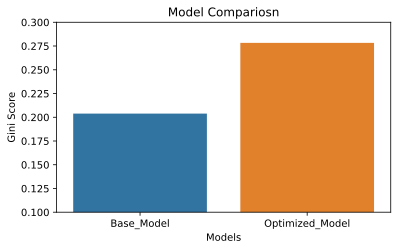

In [35]:
scoreBase = models.loc['Gini_Score', 'Default']
improvement = round(100*(scoreFinal-scoreBase)/scoreBase,2)
print("The improvement in business metric: {}%".format(improvement))

lst1 = ['Base_Model', 'Optimized_Model']
lst2 = [scoreBase, scoreFinal]

fig, ax = plt.subplots(figsize=(6,3.5))
sns.barplot(lst1, lst2, ax=ax)
ax.set_title('Model Compariosn')
ax.set_xlabel('Models')
ax.set_ylabel('Gini Score');
ax.set(ylim=(0.10, 0.30))
plt.savefig(imageDirectory + '\\model_Comparison.png', dpi=140,  bbox_inches='tight')

### <font color=green>Improvement by hyperparameter tuning: 36.52%</font>